# Building (Peak vs. Off Peak) Histograms

### How to run this notebook:
* Give date and type of vehicle as arguments
* If simplified etapas file does not exist, then run RunDailyEtapasBuilder.runSimplifyEtapas(). If it already exists, then omit it
* If simplified perfiles file does not exist, then run RunDailyEtapasBuilder.runSimplifyPerfiles(). If it already exists, then omit it. TODO: This is not (yet) needed

Run the builder in this order:
1. etapas_df = RunDailyEtapasBuilder.loadSimplifiedEtapas()
2. merged_df = RunDailyEtapasBuilder.includeTorniquetesDate(etapas_df)
3. clean_df = RunDailyEtapasBuilder.cleanDataFrame(merged_df)
4. sorted_df = RunDailyEtapasBuilder.sortDataFrame(clean_df)

In [1]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import datetime as dt

In [2]:
import RunDailyEtapasBuilder

Enter the date to analyze: 2017-07-19
Enter the vehicle to analyze: BUS
Consider ZP in perfiles file (0/1)?: 0


* Running the builder of the dataframe

In [3]:
#RunDailyEtapasBuilder.runSimplifyEtapas()
etapas_df = RunDailyEtapasBuilder.loadSimplifiedEtapas()
merged_df = RunDailyEtapasBuilder.mergeTurnstileData(etapas_df)
clean_df = RunDailyEtapasBuilder.cleanDataFrame(merged_df)
sorted_df = RunDailyEtapasBuilder.sortDataFrame(clean_df)
sorted_df = sorted_df.reset_index()

Not found in turnstile database: 1637796


* Counting.

In [4]:
print(etapas_df['id'].count())
print(merged_df['id'].count())
print(clean_df['id'].count())
print(sorted_df['id'].count())

2361310
2361310
2326044
2326044


* Adding necessary attributes

In [5]:
sorted_df['mismo_paradero'] = (sorted_df['par_subida']==sorted_df['par_subida'].shift()).fillna(False)
sorted_df['misma_patente'] = (sorted_df['sitio_subida']==sorted_df['sitio_subida'].shift()).fillna(False)
sorted_df['mismo_servicio'] = (sorted_df['servicio_subida']==sorted_df['servicio_subida'].shift()).fillna(False)

sorted_df.loc[(sorted_df.mismo_servicio == True) & (sorted_df.mismo_paradero == True) & (sorted_df.misma_patente == True), 'diferencia_tiempo'] = (sorted_df['t_subida']-sorted_df['t_subida'].shift())

sorted_df['diferencia_tiempo_secs'] = sorted_df['diferencia_tiempo'].dt.total_seconds()
sorted_df['si_torniquete'] = (sorted_df['fecha_instalacion']<=sorted_df['t_subida'])
sorted_df['si_2017_torniquete'] = ((sorted_df['fecha_instalacion']<=sorted_df['t_subida'])&(sorted_df['fecha_instalacion']>=pd.to_datetime('2017-01-01')))

* Filtering by mismo_paradero, misma_patente and by si_torniquete. This is a key part

In [6]:
filtered_df = sorted_df[(sorted_df.mismo_servicio==True) & (sorted_df.mismo_paradero==True) & (sorted_df.misma_patente==True)]
filtered_turnstile_df = filtered_df[filtered_df.si_2017_torniquete==True]
filtered_no_turnstile_df = filtered_df[filtered_df.si_torniquete==False]

* Counting and checking

In [7]:
print(filtered_df['id'].count())
print(filtered_turnstile_df['id'].count())
print(filtered_no_turnstile_df['id'].count())
checking = filtered_turnstile_df['id'].count() + filtered_no_turnstile_df['id'].count()
print(checking)

1427569
176655
998532
1175187


* Getting rid of unecessary dataframes

In [8]:
del etapas_df
del merged_df
del clean_df

* Filtering by period (peak vs. off-peak). In this case, peak is PMA + PTA

In [9]:
off_peak_start_1 = dt.time(0,0,0)
off_peak_end_1 = dt.time(6,29,0)

peak_start_1 = dt.time(6,30,0)
peak_end_1 = dt.time(8,29,0)

off_peak_start_2 = dt.time(8,30,0)
off_peak_end_2 = dt.time(17,29,0)

peak_start_2 = dt.time(17,30,0)
peak_end_2 = dt.time(20,29,0)

off_peak_start_3 = dt.time(20,30,0)
off_peak_end_3 = dt.time(23,59,0)

* TODO: Consider reducing this

In [10]:
off_peak_turnstile_df = filtered_turnstile_df[((off_peak_start_1<=filtered_turnstile_df['t_subida'].dt.time)
                                               & (filtered_turnstile_df['t_subida'].dt.time<=off_peak_end_1))
                                               | ((off_peak_start_2<=filtered_turnstile_df['t_subida'].dt.time)
                                               & (filtered_turnstile_df['t_subida'].dt.time<=off_peak_end_2))
                                               | ((off_peak_start_3<=filtered_turnstile_df['t_subida'].dt.time)
                                               & (filtered_turnstile_df['t_subida'].dt.time<=off_peak_end_3))]

off_peak_no_turnstile_df = filtered_no_turnstile_df[((off_peak_start_1<=filtered_no_turnstile_df['t_subida'].dt.time)
                                               & (filtered_no_turnstile_df['t_subida'].dt.time<=off_peak_end_1))
                                               | ((off_peak_start_2<=filtered_no_turnstile_df['t_subida'].dt.time)
                                               & (filtered_no_turnstile_df['t_subida'].dt.time<=off_peak_end_2))
                                               | ((off_peak_start_3<=filtered_no_turnstile_df['t_subida'].dt.time)
                                               & (filtered_no_turnstile_df['t_subida'].dt.time<=off_peak_end_3))]

peak_turnstile_df = filtered_turnstile_df[((peak_start_1<=filtered_turnstile_df['t_subida'].dt.time)
                                           & (filtered_turnstile_df['t_subida'].dt.time<=peak_end_1))
                                           | ((peak_start_2<=filtered_turnstile_df['t_subida'].dt.time)
                                           & (filtered_turnstile_df['t_subida'].dt.time<=peak_end_2))]

peak_no_turnstile_df = filtered_no_turnstile_df[((peak_start_1<=filtered_no_turnstile_df['t_subida'].dt.time)
                                           & (filtered_no_turnstile_df['t_subida'].dt.time<=peak_end_1))
                                           | ((peak_start_2<=filtered_no_turnstile_df['t_subida'].dt.time)
                                           & (filtered_no_turnstile_df['t_subida'].dt.time<=peak_end_2))]

TODO: Currently, there are rows with extremely high values for the 'diferencia_tiempo' attribute (e.g. >=25 mins). <strong>Be aware of this</strong>. <strike>This should be fixed considering the idExpedicion attribute present in the corresponding 'perfiles' database. The following graphs and descriptive statistics consider only the 95th percentile for the 'diferencia_tiempo_secs' attribute.</strike>

### Filtering by diferencia_tiempo<=97th percentile in the corresponding databases. <font color="red">BE AWARE.</font>

In [11]:
off_peak_turnstile_97 = off_peak_turnstile_df.diferencia_tiempo.quantile(0.97)
print ('Percentile 97th for off_peak_turnstile database is: ' + str(off_peak_turnstile_97))
off_peak_no_turnstile_97 = off_peak_no_turnstile_df.diferencia_tiempo.quantile(0.97)
print ('Percentile 97th for off_peak_no_turnstile database is: ' + str(off_peak_no_turnstile_97))
peak_turnstile_97 = peak_turnstile_df.diferencia_tiempo.quantile(0.97)
print ('Percentile 97th for peak_turnstile database is: ' + str(peak_turnstile_97))
peak_no_turnstile_97 = peak_no_turnstile_df.diferencia_tiempo.quantile(0.97)
print ('Percentile 97th for peak_no_turnstile database is: ' + str(peak_no_turnstile_97))

Percentile 97th for off_peak_turnstile database is: 0 days 00:00:27
Percentile 97th for off_peak_no_turnstile database is: 0 days 00:00:26
Percentile 97th for peak_turnstile database is: 0 days 00:00:24
Percentile 97th for peak_no_turnstile database is: 0 days 00:00:24


In [12]:
off_peak_turnstile_97_df = off_peak_turnstile_df[off_peak_turnstile_df.diferencia_tiempo<=off_peak_turnstile_97]
off_peak_no_turnstile_97_df = off_peak_no_turnstile_df[off_peak_no_turnstile_df.diferencia_tiempo<=off_peak_no_turnstile_97]
peak_turnstile_97_df = peak_turnstile_df[peak_turnstile_df.diferencia_tiempo<=peak_turnstile_97]
peak_no_turnstile_97_df = peak_no_turnstile_df[peak_no_turnstile_df.diferencia_tiempo<=peak_no_turnstile_97]

In [13]:
off_peak_turnstile_97_df.describe()

,index,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,1.054880e+05,1.054880e+05,105488.000000,105488,105488.000000
mean,1.155783e+06,1.826317e+09,1.622810,0 days 00:00:06.031444,6.031444
std,6.920017e+05,1.415174e+09,0.866035,0 days 00:00:04.166893,4.166893
min,0.000000e+00,1.091258e+06,1.000000,0 days 00:00:00,0.000000
25%,5.536888e+05,4.233079e+08,1.000000,0 days 00:00:04,4.000000
50%,1.156095e+06,1.914950e+09,1.000000,0 days 00:00:05,5.000000
75%,1.754372e+06,3.168960e+09,2.000000,0 days 00:00:07,7.000000
max,2.361240e+06,4.288128e+09,12.000000,0 days 00:00:27,27.000000


In [14]:
off_peak_no_turnstile_97_df.describe()

,index,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,5.854340e+05,5.854340e+05,585434.000000,585434,585434.000000
mean,1.176736e+06,1.861731e+09,1.657107,0 days 00:00:03.745175,3.745175
std,6.823555e+05,1.405708e+09,0.885564,0 days 00:00:03.780122,3.780122
min,1.000000e+00,1.091258e+06,1.000000,0 days 00:00:00,0.000000
25%,5.906932e+05,4.262212e+08,1.000000,0 days 00:00:02,2.000000
50%,1.175766e+06,1.985196e+09,1.000000,0 days 00:00:03,3.000000
75%,1.764952e+06,3.170305e+09,2.000000,0 days 00:00:04,4.000000
max,2.361305e+06,4.293259e+09,22.000000,0 days 00:00:26,26.000000


In [15]:
peak_turnstile_97_df.describe()

,index,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,6.525400e+04,6.525400e+04,65254.000000,65254,65254.000000
mean,1.179331e+06,1.865527e+09,1.568026,0 days 00:00:05.501823,5.501824
std,6.818507e+05,1.407537e+09,0.825025,0 days 00:00:03.552965,3.552965
min,2.700000e+01,1.342554e+06,1.000000,0 days 00:00:00,0.000000
25%,5.830598e+05,4.256764e+08,1.000000,0 days 00:00:03,3.000000
50%,1.179826e+06,2.009796e+09,1.000000,0 days 00:00:04,4.000000
75%,1.769527e+06,3.170769e+09,2.000000,0 days 00:00:06,6.000000
max,2.361291e+06,4.293088e+09,13.000000,0 days 00:00:24,24.000000


In [16]:
peak_no_turnstile_97_df.describe()

,index,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,3.791980e+05,3.791980e+05,379198.000000,379198,379198.000000
mean,1.197602e+06,1.898195e+09,1.638324,0 days 00:00:03.499570,3.499570
std,6.744314e+05,1.399160e+09,0.856263,0 days 00:00:03.442124,3.442124
min,4.000000e+00,1.092170e+06,1.000000,0 days 00:00:00,0.000000
25%,6.150778e+05,4.288512e+08,1.000000,0 days 00:00:02,2.000000
50%,1.198578e+06,2.037457e+09,1.000000,0 days 00:00:03,3.000000
75%,1.783058e+06,3.172209e+09,2.000000,0 days 00:00:04,4.000000
max,2.361308e+06,4.293295e+09,16.000000,0 days 00:00:24,24.000000


* Plotting

In [17]:
colors = [(85,98,112),(78,205,196),(199,244,100),(255,107,107),(196,77,88)]
for i in range(len(colors)):
    r, g, b = colors[i]  
    colors[i] = (r / 255., g / 255., b / 255.)

In [18]:
off_peak_turnstile_values = off_peak_turnstile_97_df.diferencia_tiempo_secs.values
off_peak_no_turnstile_values = off_peak_no_turnstile_97_df.diferencia_tiempo_secs.values
peak_turnstile_values = peak_turnstile_97_df.diferencia_tiempo_secs.values
peak_no_turnstile_values = peak_no_turnstile_97_df.diferencia_tiempo_secs.values

* OFF-PEAK: turns vs. without turns

In [19]:
off_peak_max_97 = max(off_peak_turnstile_97,off_peak_no_turnstile_97).total_seconds()
bins = range(0,int(off_peak_max_97),1)

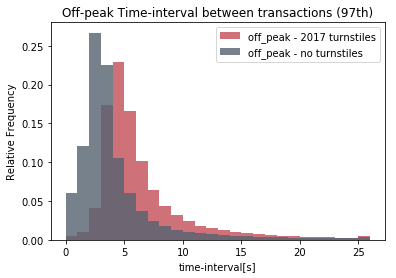

In [20]:
hist_fig, ax = plt.subplots()

plot1 = ax.hist(off_peak_turnstile_values,normed=True,bins=bins,color=colors[4], alpha=0.8, label='off_peak - 2017 turnstiles')
plot2 = ax.hist(off_peak_no_turnstile_values,normed=True,bins=bins,color=colors[0], alpha = 0.8, label='off_peak - no turnstiles')


ax.set_title('Off-peak Time-interval between transactions (97th)')
ax.set_xlabel('time-interval[s]')
ax.set_ylabel('Relative Frequency')
ax.legend()
#plt.savefig('C:/Users/Tesista/Desktop/Evasion/03_report/02_Figs/5_OFFPEAK-2017-07-19.pdf')
#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/OFFPEAK-2017-03-01.pdf')

* PEAK: turns vs. without turns

In [21]:
peak_max_97 = max(peak_turnstile_97,peak_no_turnstile_97).total_seconds()
bins = range(0,int(peak_max_97),1)

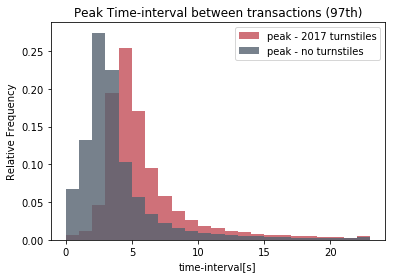

In [22]:
hist_fig, ax = plt.subplots()

plot1 = ax.hist(peak_turnstile_values,normed=True,bins=bins,color=colors[4], alpha=0.8, label='peak - 2017 turnstiles')
plot2 = ax.hist(peak_no_turnstile_values,normed=True,bins=bins,color=colors[0], alpha = 0.8, label='peak - no turnstiles')


ax.set_title('Peak Time-interval between transactions (97th)')
ax.set_xlabel('time-interval[s]')
ax.set_ylabel('Relative Frequency')
ax.legend()
#plt.savefig('C:/Users/Tesista/Desktop/Evasion/03_report/02_Figs/5_PEAK-2017-07-19.pdf')
#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/PEAK-2017-03-01.pdf')

* TURNS: PEAK vs. OFF-PEAK

In [23]:
turns_max_97 = max(off_peak_turnstile_97,peak_turnstile_97).total_seconds()
bins = range(0,int(turns_max_97),1)

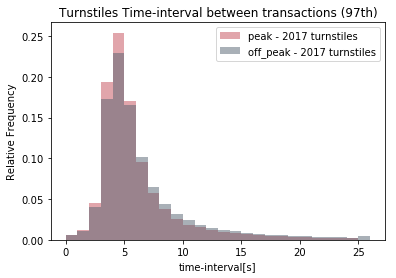

In [24]:
hist_fig, ax = plt.subplots()

plot2 = ax.hist(peak_turnstile_values,normed=True,bins=bins,color=colors[4], alpha = 0.5, label='peak - 2017 turnstiles')
plot1 = ax.hist(off_peak_turnstile_values,normed=True,bins=bins,color=colors[0], alpha=0.5, label='off_peak - 2017 turnstiles')



ax.set_title('Turnstiles Time-interval between transactions (97th)')
ax.set_xlabel('time-interval[s]')
ax.set_ylabel('Relative Frequency')
ax.legend()
#plt.savefig('C:/Users/Tesista/Desktop/Evasion/03_report/02_Figs/5_turnstiles_peakoffpeak-2017-07-19.pdf')
#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/turnstiles_peakoffpeak-2017-03-01.pdf')

* NO-TURNS: PEAK VS. OFF-PEAK

In [25]:
no_turns_max_97 = max(off_peak_no_turnstile_97,peak_no_turnstile_97).total_seconds()
bins = range(0,int(no_turns_max_97),1)

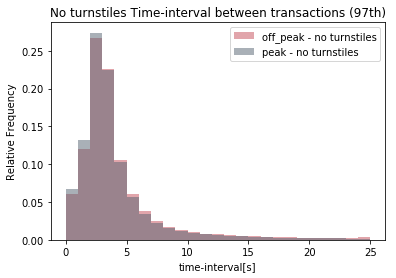

In [26]:
hist_fig, ax = plt.subplots()

plot1 = ax.hist(off_peak_no_turnstile_values,normed=True,bins=bins,color=colors[4], alpha=0.5, label='off_peak - no turnstiles')
plot2 = ax.hist(peak_no_turnstile_values,normed=True,bins=bins,color=colors[0], alpha = 0.5, label='peak - no turnstiles')


ax.set_title('No turnstiles Time-interval between transactions (97th)')
ax.set_xlabel('time-interval[s]')
ax.set_ylabel('Relative Frequency')
ax.legend()
#plt.savefig('C:/Users/Tesista/Desktop/Evasion/03_report/02_Figs/5_no-turnstiles_peakoffpeak-2017-07-19.pdf')
#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/no-turnstiles_peakoffpeak-2017-03-01.pdf')

In [27]:
import scipy as sp
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t.ppf((1+confidence)/2., n-1)
    return h, m-h, m, m+h

In [28]:
mean_confidence_interval(off_peak_turnstile_97_df['diferencia_tiempo_secs'])

(0.0251457108839328,
 6.0062986240167202,
 6.0314443349006526,
 6.0565900457845849)

In [29]:
mean_confidence_interval(off_peak_no_turnstile_97_df['diferencia_tiempo_secs'])

(0.0096831319930447864,
 3.7354922421738124,
 3.7451753741668572,
 3.754858506159902)

In [30]:
mean_confidence_interval(peak_turnstile_97_df['diferencia_tiempo_secs'])

(0.027261109924063016,
 5.4745625330710022,
 5.5018236429950651,
 5.529084752919128)

In [31]:
mean_confidence_interval(peak_no_turnstile_97_df['diferencia_tiempo_secs'])

(0.010955772632077986,
 3.4886143727800816,
 3.4995701454121595,
 3.5105259180442374)

### Closed